In [22]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("ComplexHeatmap")
# install.packages(c('ClusterR','tidyverse'))
suppressMessages(require(ComplexHeatmap))
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))
require(ClusterR)
require(pracma)

In [19]:
(dat <- fread('../data_processed/plot_dat.csv')) %>% head(1)
dat %>% dim

0.5_867451,0.5_867454,0.5_867457,0.5_867478,0.5_867481,0.5_867484,1_926614,1_494014,1_494017,1_494020,⋯,7_685178,7_685217,7_821662,7_823408,7_839434,7_839446,7_833455,7_840319,7_834112,7_995287
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0,0,-43.71738,21.13995,25.22552,13.91107,⋯,0,0,0,0,0,0,0,0,0,0


[1] 10560    74

elapsed time is 11.332000 seconds 


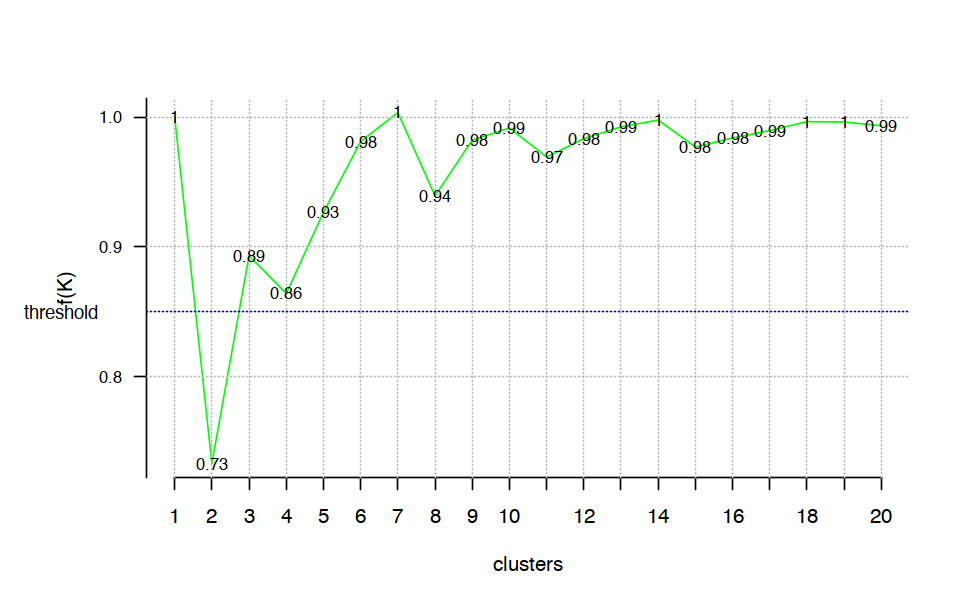

In [74]:
tic()
opt = Optimal_Clusters_KMeans(dat, max_clusters = 20, plot_clusters = T, criterion = "distortion_fK", 
    fK_threshold = 0.85, initializer = "optimal_init", tol_optimal_init = 0.2)
toc()

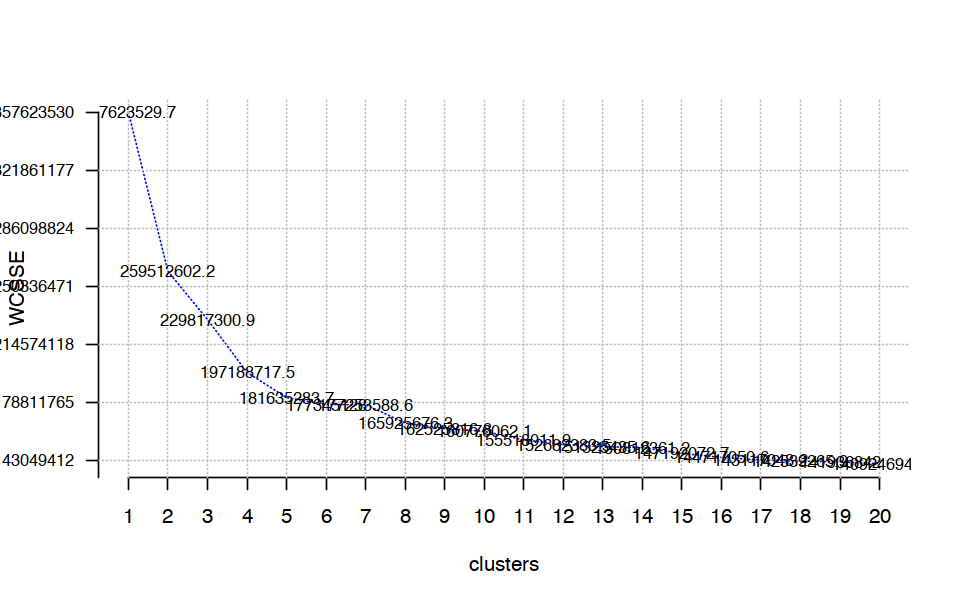

In [73]:
options(repr.plot.width = 8, repr.plot.height = 5)

opt = Optimal_Clusters_KMeans(dat, max_clusters = 20, plot_clusters = T, criterion = "WCSSE", 
    fK_threshold = 0.85, initializer = "optimal_init", tol_optimal_init = 0.2)

In [77]:
pal_atac <- colorRampPalette(c("#3361A5", "#248AF3", "#14B3FF", "#88CEEF", "#C1D5DC", 
    "#EAD397", "#FDB31A", "#E42A2A", "#A31D1D"))(100)



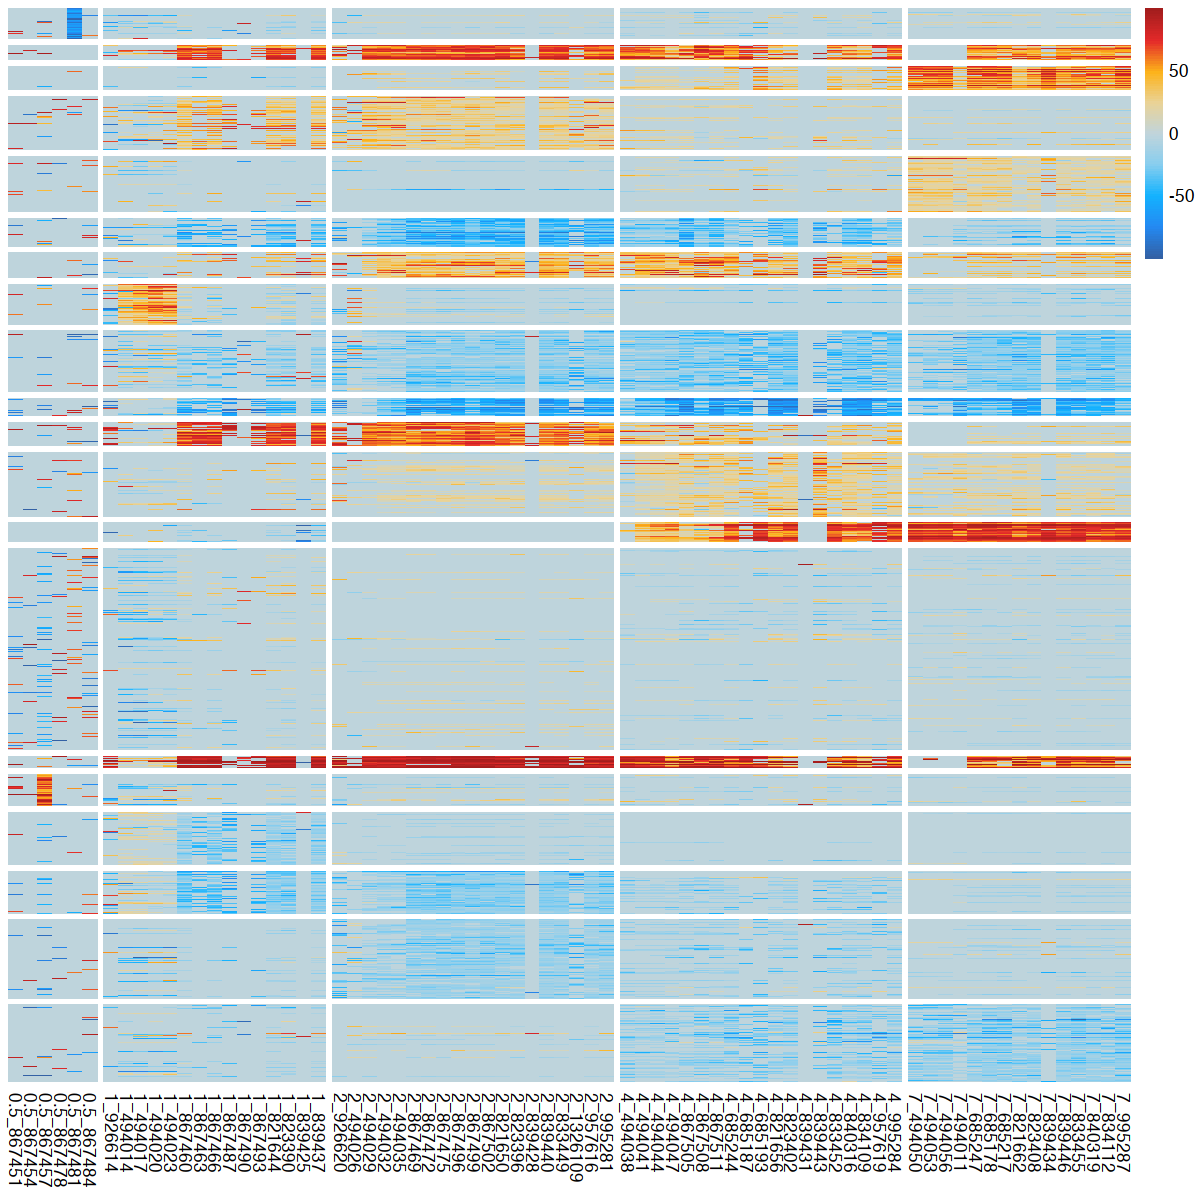

In [78]:
options(repr.plot.width = 10, repr.plot.height = 10)
doKmeans = function(dat_ = dat, k = 20,...) {
    
    km_rc = KMeans_rcpp(dat_, clusters = k, num_init = 5, max_iters = 100, initializer = "optimal_init", 
        verbose = F)
    row.ord <- (dat_ %>% rownames)[order(km_rc$clusters)]
    row.gap <- km_rc$clusters[order(km_rc$clusters)] %>% table %>% cumsum
    col.gap = dat_ %>% colnames %>% sapply(., function(x) (strsplit(x, split = "_") %>% 
        unlist)[1]) %>% table %>% cumsum
    
    pheatmap(dat_[row.ord %>% as.integer, ], gaps_row = row.gap, gaps_col = col.gap, 
        scale = "none", color = pal_atac, cluster_rows = F, cluster_cols = F, show_rownames = F, 
        ...)
}
doKmeans()                                          

In [82]:
pdf(file = "kmeans_init.pdf", width = 10, height = 10)
for (k_ in 4:20) {
    print(k_)
    doKmeans(k = k_)
}
dev.off()

[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20


pdf 
  3

pdf 
  3

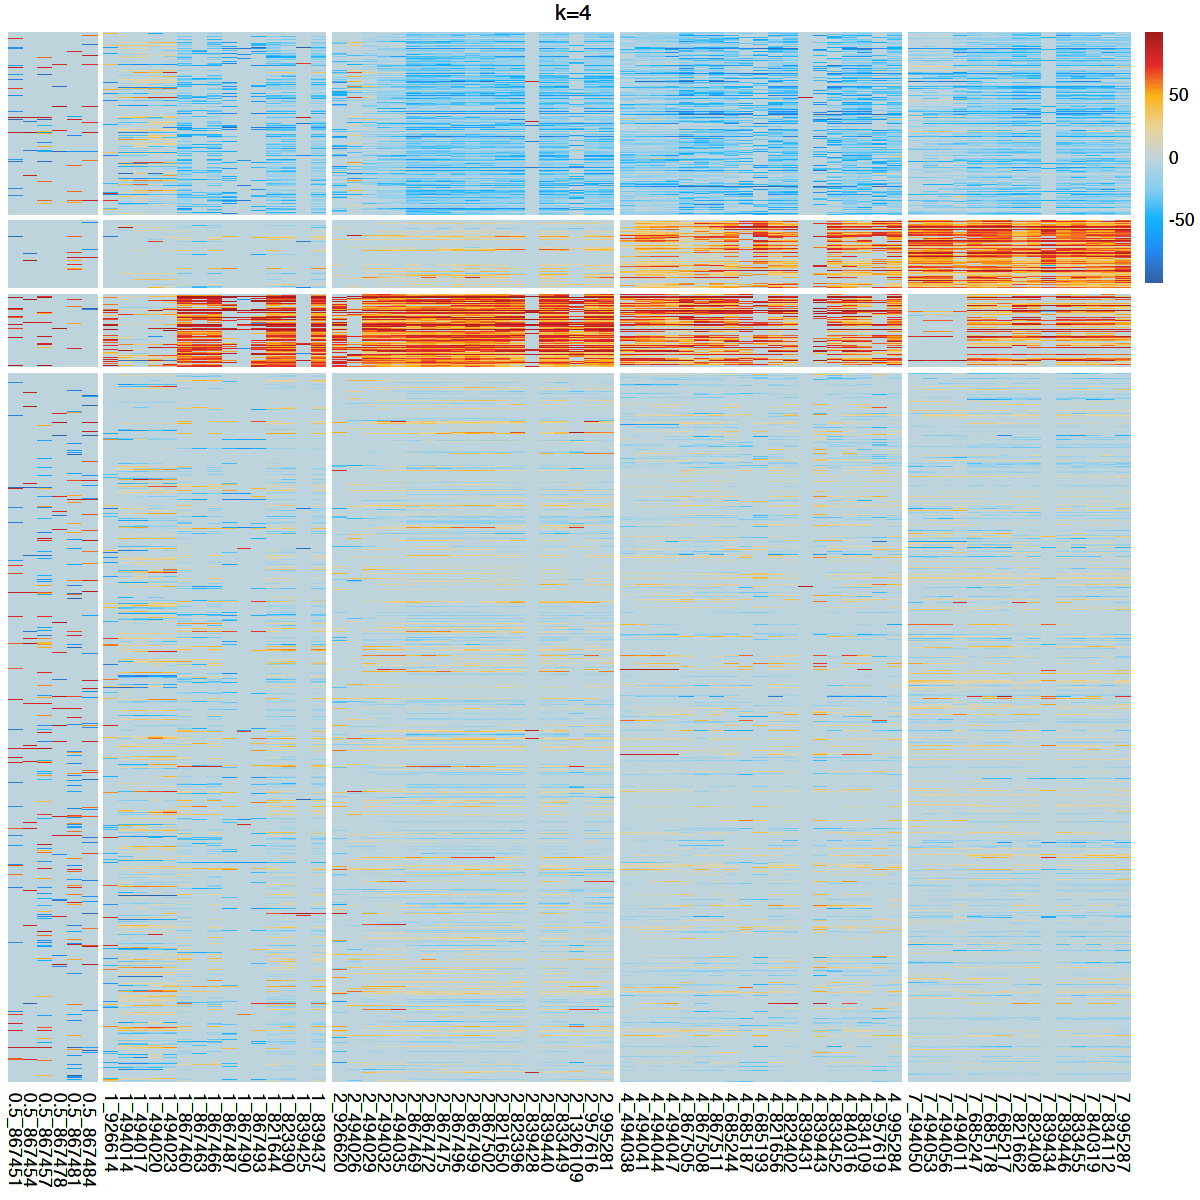

In [97]:
pdf(file = "kmeans_init.pdf", width = 10, height = 10, onefile = T)
out = doKmeans(k = 4, main = paste0("k=", 4))
print(out)
dev.off()
system("open kmeans_init.pdf")

In [96]:
pdf(file = "kmeans_init.pdf", width = 10, height = 10)
print(out)
dev.off()
system("open kmeans_init.pdf")

pdf 
  2